## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.metrics import R2Score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-17 12:04:56.126761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:00:22.7270000Z', 'time_close': '2023-09-17T16:04:44.5860000Z', 'price_open': 1634.9, 'price_high': 1635.6, 'price_low': 1620.7, 'price_close': 1629.9, 'volume_traded': 919.74810426, 'trades_count': 2052}, {'time_period_start': '2023-09-16T00:00:00.0000000Z', 'time_period_end': '2023-09-17T00:00:00.0000000Z', 'time_open': '2023-09-16T00:00:18.8370000Z', 'time_close': '2023-09-16T23:59:46.7840000Z', 'price_open': 1642.4, 'price_high': 1652.3, 'price_low': 1632.1, 'price_close': 1635, 'volume_traded': 1343.66683579, 'trades_count': 3983}, {'time_period_start': '2023-09-15T00:00:00.0000000Z', 'time_period_end': '2023-09-16T00:00:00.0000000Z', 'time_open': '2023-09-15T00:00:00.4470000Z', 'time_close': '2023-09-15T23:59:48.2460000Z', 'price_open': 1627.1, 'price_high': 1653.1, 'price_low': 1612, 'price_close': 1641.5, 'volume_traded': 3623.07439861, 'trades_co

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:00:22.7270000Z,2023-09-17T16:04:44.5860000Z,1634.9,1635.6,1620.7,1629.9,919.748104,2052
1,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:18.8370000Z,2023-09-16T23:59:46.7840000Z,1642.4,1652.3,1632.1,1635.0,1343.666836,3983
2,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:00.4470000Z,2023-09-15T23:59:48.2460000Z,1627.1,1653.1,1612.0,1641.5,3623.074399,5783
3,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:04.4670000Z,2023-09-14T23:59:58.0310000Z,1608.1,1644.4,1607.5,1627.1,5650.199148,5572
4,2023-09-13T00:00:00.0000000Z,2023-09-14T00:00:00.0000000Z,2023-09-13T00:00:26.8010000Z,2023-09-13T23:58:55.8280000Z,1593.2,1618.2,1581.8,1608.1,4672.302039,4862


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


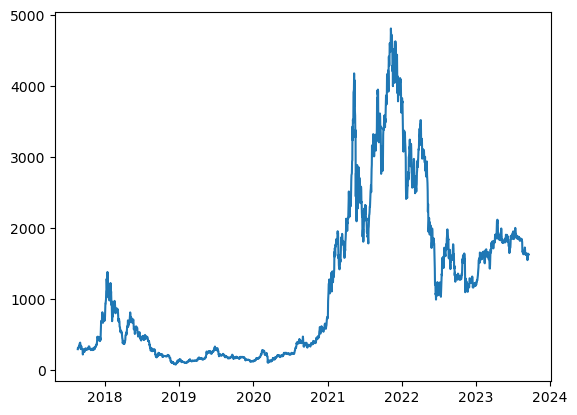

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np)



# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2203, 7), (2203,), (2203,))

In [8]:
# non_positive_indices = np.where(shifted_df_as_np <= 0)
# print(non_positive_indices)


In [9]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1762, 7), (1762,), (220, 7), (220,), (221, 7), (221,))

In [10]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-17 12:05:04.688799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
56/56 [==============================] - 3s 16ms/step - loss: 15.3129 - mean_absolute_error: 3.2238 - val_loss: 0.8796 - val_mean_absolute_error: 0.9269
Epoch 2/100
56/56 [==============================] - 0s 6ms/step - loss: 1.1067 - mean_absolute_error: 0.9058 - val_loss: 0.5796 - val_mean_absolute_error: 0.7506
Epoch 3/100
56/56 [==============================] - 0s 6ms/step - loss: 0.4496 - mean_absolute_error: 0.5420 - val_loss: 0.0039 - val_mean_absolute_error: 0.0459
Epoch 4/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0691 - val_loss: 0.0041 - val_mean_absolute_error: 0.0478
Epoch 5/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0735 - val_loss: 0.0036 - val_mean_absolute_error: 0.0424
Epoch 6/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0618 - val_loss: 0.0039 - val_mean_absolute_error: 0.0442
Epoch 7/100
56/56 [=

Epoch 51/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0480 - val_loss: 0.0028 - val_mean_absolute_error: 0.0367
Epoch 52/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0467 - val_loss: 0.0028 - val_mean_absolute_error: 0.0389
Epoch 53/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0556 - val_loss: 0.0029 - val_mean_absolute_error: 0.0381
Epoch 54/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_error: 0.0592 - val_loss: 0.0092 - val_mean_absolute_error: 0.0872
Epoch 55/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0524 - val_loss: 0.0045 - val_mean_absolute_error: 0.0528
Epoch 56/100
56/56 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0502 - val_loss: 0.0043 - val_mean_absolute_error: 0.0512
Epoch 57/100
56/

56/56 [==============================] - 1s 2ms/step


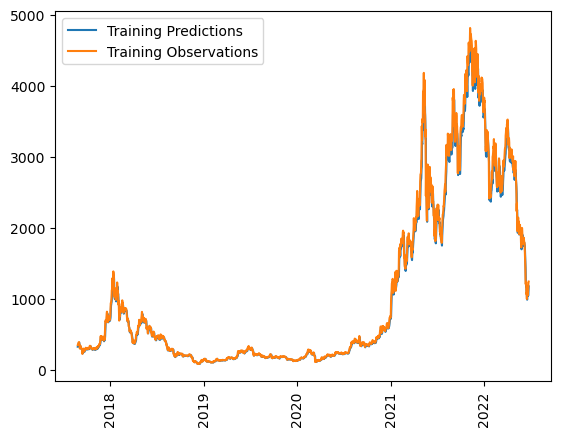

In [11]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [12]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002630630973726511
Val MAE: 0.03933800756931305


7/7 [==============================] - 0s 3ms/step


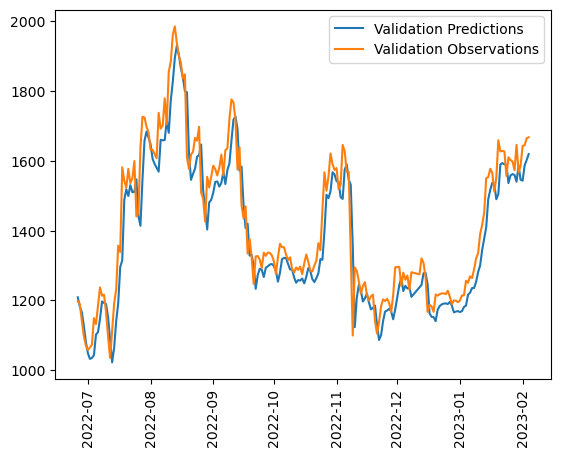

In [13]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [14]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0012369467876851559
Test MAE: 0.02908329851925373


7/7 [==============================] - 0s 3ms/step


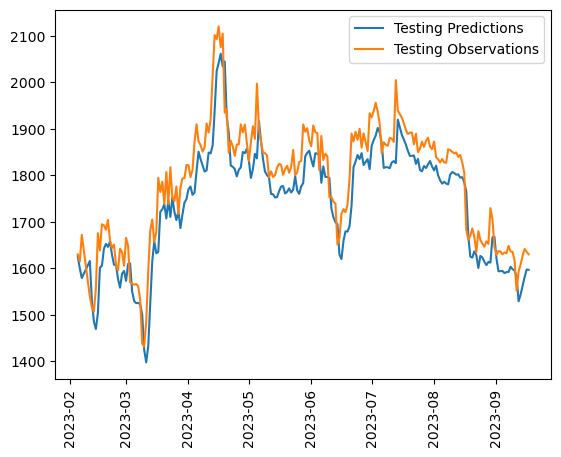

In [15]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [16]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.7681394745568351


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [17]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [18]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((859,), (859, 7), (859,), (132,), (132, 7), (132,), (111,), (111, 7), (111,))

In [19]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
27/27 [==============================] - 3s 26ms/step - loss: 53.4012 - mean_absolute_error: 7.2766 - val_loss: 50.9884 - val_mean_absolute_error: 7.1401
Epoch 2/200
27/27 [==============================] - 0s 6ms/step - loss: 49.7125 - mean_absolute_error: 7.0185 - val_loss: 47.0725 - val_mean_absolute_error: 6.8604
Epoch 3/200
27/27 [==============================] - 0s 6ms/step - loss: 45.2766 - mean_absolute_error: 6.6957 - val_loss: 42.1030 - val_mean_absolute_error: 6.4882
Epoch 4/200
27/27 [==============================] - 0s 6ms/step - loss: 39.8310 - mean_absolute_error: 6.2749 - val_loss: 36.1423 - val_mean_absolute_error: 6.0113
Epoch 5/200
27/27 [==============================] - 0s 6ms/step - loss: 33.4521 - mean_absolute_error: 5.7423 - val_loss: 29.2102 - val_mean_absolute_error: 5.4040
Epoch 6/200
27/27 [==============================] - 0s 6ms/step - loss: 25.9444 - mean_absolute_error: 5.0476 - val_loss: 21.2054 - val_mean_absolute_error: 4.6042
Epoch 7/2

Epoch 51/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_error: 0.0570 - val_loss: 0.0014 - val_mean_absolute_error: 0.0289
Epoch 52/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0555 - val_loss: 0.0018 - val_mean_absolute_error: 0.0350
Epoch 53/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0557 - val_loss: 0.0024 - val_mean_absolute_error: 0.0417
Epoch 54/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0016 - val_mean_absolute_error: 0.0325
Epoch 55/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0544 - val_loss: 0.0013 - val_mean_absolute_error: 0.0278
Epoch 56/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0544 - val_loss: 0.0013 - val_mean_absolute_error: 0.0278
Epoch 57/200
27/

Epoch 101/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0518 - val_loss: 0.0013 - val_mean_absolute_error: 0.0275
Epoch 102/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.0524 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316
Epoch 103/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_absolute_error: 0.0513 - val_loss: 0.0014 - val_mean_absolute_error: 0.0279
Epoch 104/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0521 - val_loss: 0.0021 - val_mean_absolute_error: 0.0387
Epoch 105/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0521 - val_loss: 0.0013 - val_mean_absolute_error: 0.0269
Epoch 106/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0506 - val_loss: 0.0013 - val_mean_absolute_error: 0.0267
Epoch 107/

27/27 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0013 - val_mean_absolute_error: 0.0285
Epoch 151/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0516 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314
Epoch 152/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0515 - val_loss: 0.0018 - val_mean_absolute_error: 0.0341
Epoch 153/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 0.0012 - val_mean_absolute_error: 0.0263
Epoch 154/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0493 - val_loss: 0.0016 - val_mean_absolute_error: 0.0327
Epoch 155/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0493 - val_loss: 0.0013 - val_mean_absolute_error: 0.0275
Epoch 156/200
27/27 [===

Epoch 200/200
27/27 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0485 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257


27/27 [==============================] - 1s 2ms/step


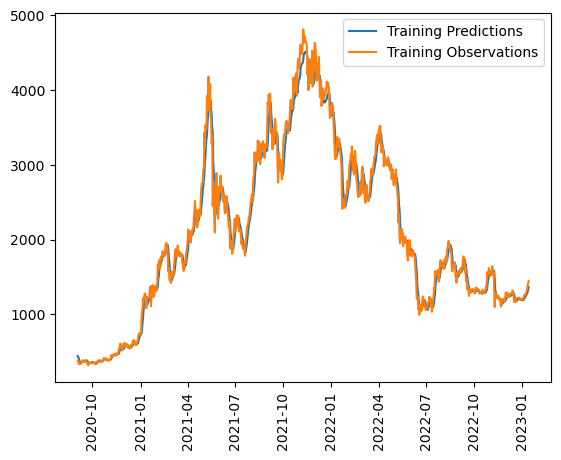

In [20]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [21]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0011925897561013699
Val MAE: 0.02571883425116539


5/5 [==============================] - 0s 3ms/step


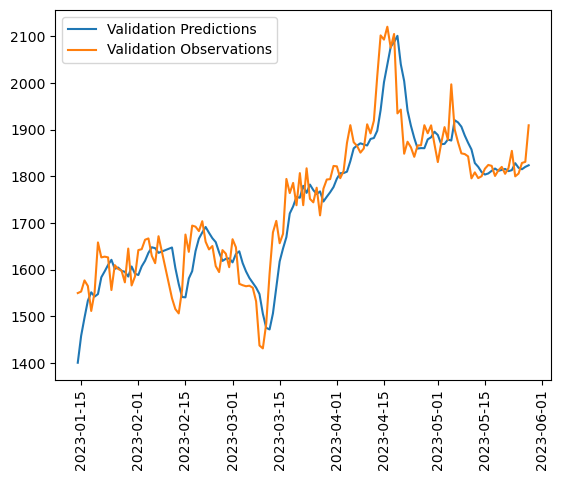

In [22]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [23]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0005199708975851536
Test MAE: 0.015797769650816917


In [24]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 3ms/step
R2 Score:  0.8663668871653294


4/4 [==============================] - 0s 3ms/step


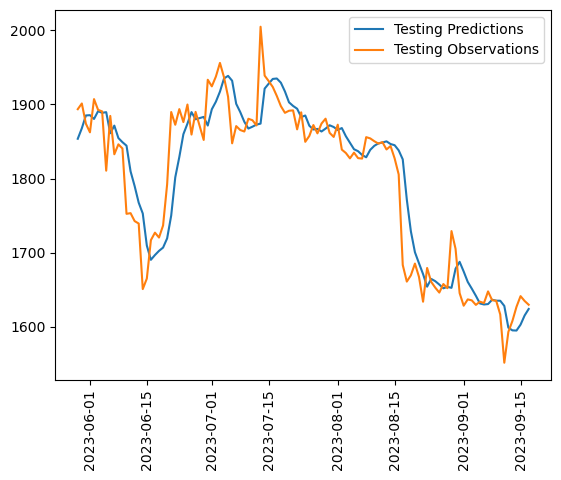

In [25]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [42]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
27/27 [==============================] - 3s 31ms/step - loss: 29.8990 - mean_absolute_error: 5.1539 - val_loss: 1.1518 - val_mean_absolute_error: 1.0703
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 1.2229 - mean_absolute_error: 0.8969 - val_loss: 0.3226 - val_mean_absolute_error: 0.5624
Epoch 3/300
27/27 [==============================] - 0s 9ms/step - loss: 0.4649 - mean_absolute_error: 0.5442 - val_loss: 0.0071 - val_mean_absolute_error: 0.0670
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3815 - mean_absolute_error: 0.4906 - val_loss: 0.0086 - val_mean_absolute_error: 0.0721
Epoch 5/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3541 - mean_absolute_error: 0.4700 - val_loss: 0.0108 - val_mean_absolute_error: 0.0835
Epoch 6/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3046 - mean_absolute_error: 0.4401 - val_loss: 0.0119 - val_mean_absolute_error: 0.0920
Epoch 7/300
27/27 [=

Epoch 51/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0068 - mean_absolute_error: 0.0647 - val_loss: 0.0022 - val_mean_absolute_error: 0.0391
Epoch 52/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0524 - val_loss: 0.0015 - val_mean_absolute_error: 0.0309
Epoch 53/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0551 - val_loss: 0.0027 - val_mean_absolute_error: 0.0451
Epoch 54/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0516 - val_loss: 0.0023 - val_mean_absolute_error: 0.0412
Epoch 55/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0585 - val_loss: 0.0017 - val_mean_absolute_error: 0.0339
Epoch 56/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0013 - val_mean_absolute_error: 0.0286
Epoch 57/300
2

Epoch 101/300
27/27 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_absolute_error: 0.0539 - val_loss: 0.0018 - val_mean_absolute_error: 0.0357
Epoch 102/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0517 - val_loss: 0.0014 - val_mean_absolute_error: 0.0283
Epoch 103/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0444 - val_loss: 0.0017 - val_mean_absolute_error: 0.0329
Epoch 104/300
27/27 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0532 - val_loss: 0.0027 - val_mean_absolute_error: 0.0445
Epoch 105/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0587 - val_loss: 0.0014 - val_mean_absolute_error: 0.0295
Epoch 106/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_absolute_error: 0.0475 - val_loss: 0.0018 - val_mean_absolute_error: 0.0357
Epoch 107

27/27 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0451 - val_loss: 9.0200e-04 - val_mean_absolute_error: 0.0220
Epoch 151/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0046 - val_mean_absolute_error: 0.0623
Epoch 152/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_absolute_error: 0.0530 - val_loss: 0.0012 - val_mean_absolute_error: 0.0269
Epoch 153/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0433 - val_loss: 9.3211e-04 - val_mean_absolute_error: 0.0227
Epoch 154/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_absolute_error: 0.0443 - val_loss: 0.0028 - val_mean_absolute_error: 0.0476
Epoch 155/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0577 - val_loss: 0.0054 - val_mean_absolute_error: 0.0682
Epoch 156/300
27

27/27 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0487 - val_loss: 0.0064 - val_mean_absolute_error: 0.0748
Epoch 200/300
27/27 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0014 - val_mean_absolute_error: 0.0317
Epoch 201/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0016 - val_mean_absolute_error: 0.0330
Epoch 202/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0473 - val_loss: 0.0015 - val_mean_absolute_error: 0.0315
Epoch 203/300
27/27 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0485 - val_loss: 0.0038 - val_mean_absolute_error: 0.0561
Epoch 204/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0540 - val_loss: 0.0024 - val_mean_absolute_error: 0.0436
Epoch 205/300
27/27 [===

27/27 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_absolute_error: 0.0456 - val_loss: 7.9020e-04 - val_mean_absolute_error: 0.0205
Epoch 249/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_absolute_error: 0.0393 - val_loss: 0.0019 - val_mean_absolute_error: 0.0379
Epoch 250/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0405 - val_loss: 0.0030 - val_mean_absolute_error: 0.0481
Epoch 251/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0473 - val_loss: 0.0023 - val_mean_absolute_error: 0.0418
Epoch 252/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0426 - val_loss: 9.8989e-04 - val_mean_absolute_error: 0.0239
Epoch 253/300
27/27 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0637 - val_loss: 9.3208e-04 - val_mean_absolute_error: 0.0243
Epoch 254/30

27/27 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0025 - val_mean_absolute_error: 0.0435
Epoch 298/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 8.1316e-04 - val_mean_absolute_error: 0.0211
Epoch 299/300
27/27 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0466 - val_loss: 0.0071 - val_mean_absolute_error: 0.0794
Epoch 300/300
27/27 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 8.1057e-04 - val_mean_absolute_error: 0.0208


27/27 [==============================] - 1s 4ms/step


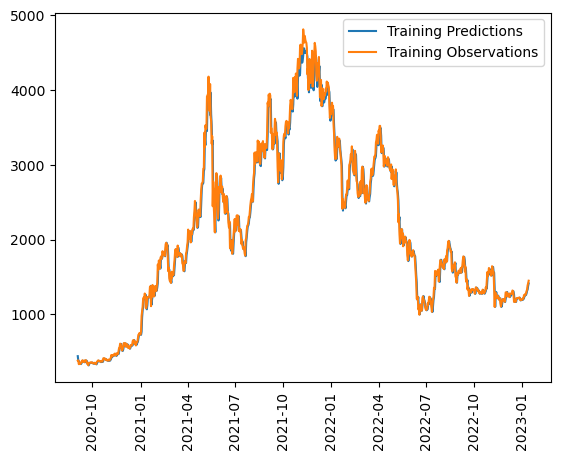

In [43]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [44]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.000810566998552531
Val MAE: 0.020813338458538055


5/5 [==============================] - 0s 6ms/step


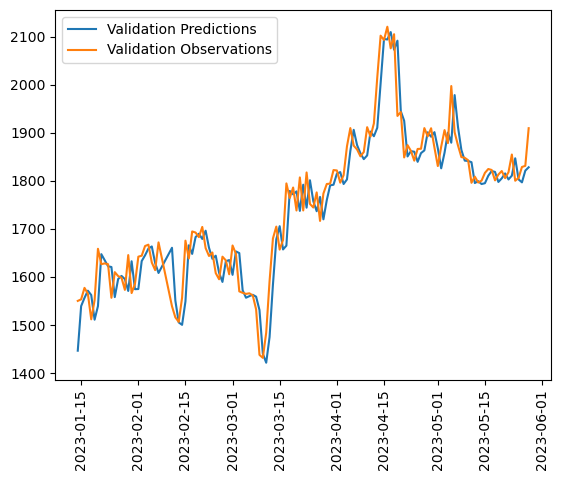

In [45]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [46]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0003727721923496574
Test MAE: 0.012490586377680302


4/4 [==============================] - 0s 4ms/step


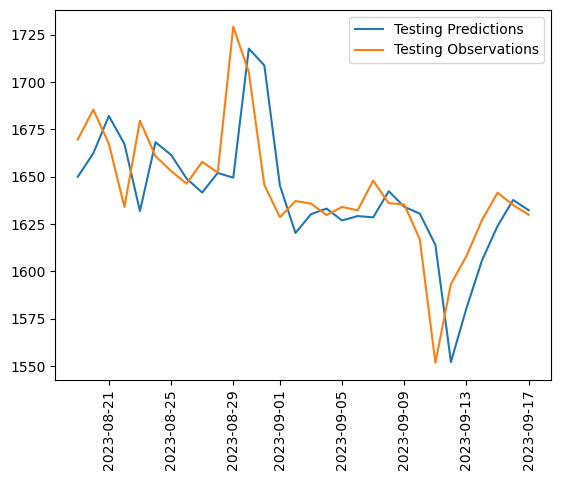

In [47]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [48]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9041971777215054


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [49]:


# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 14

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, lookback, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# Assuming 'predictions' contains your 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 48ms/step
[7.397728, 7.394795, 7.392114, 7.3895373, 7.3870444, 7.3845882, 7.382141, 7.379699, 7.3772583, 7.374819, 7.372381, 7.3699455, 7.3675137, 7.3650837]
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25
2023-09-26
2023-09-27
2023-09-28
2023-09-29
2023-09-30
2023-10-01


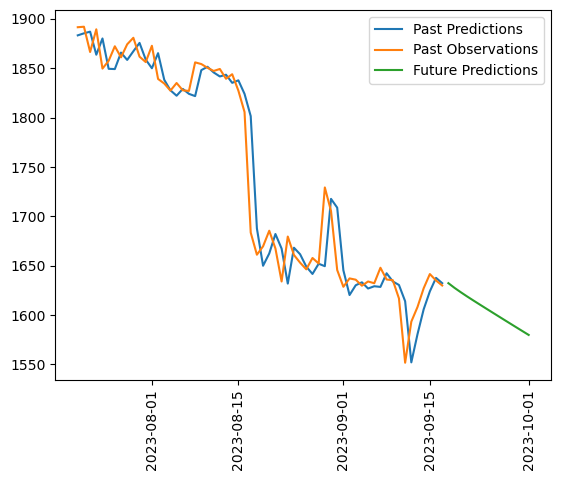

In [50]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [51]:
# Export model to HDF5 file
model.save("H5_Files/eth_7_day_1.h5")

In [52]:
# Export model to HDF5 file
model2.save("H5_Files/eth_7_day_2.h5")

In [53]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day_3.h5")

In [54]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-19,1736.8,1678.855469,1706.962158,1718.279175
2023-06-20,1792.4,1689.763550,1719.407593,1729.692627
2023-06-21,1889.8,1734.219971,1750.162598,1783.237915
2023-06-22,1872.6,1817.655762,1801.679688,1880.231567
2023-06-23,1893.7,1829.594971,1829.154419,1876.620117
...,...,...,...,...
2023-09-13,1608.1,1543.482300,1595.329346,1580.555786
2023-09-14,1627.1,1562.307251,1595.095093,1605.810425
2023-09-15,1641.5,1581.323242,1603.026489,1623.952271


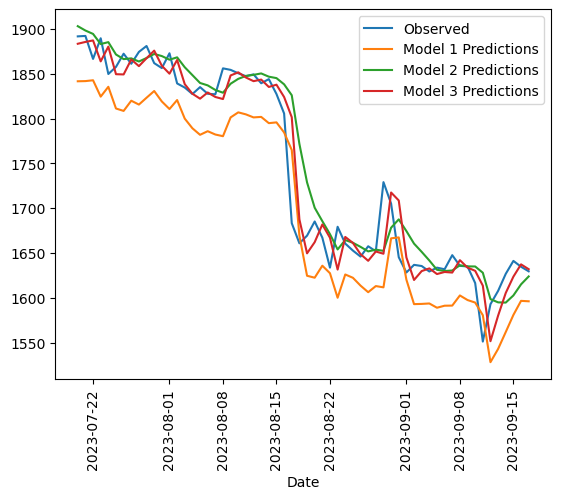

In [55]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [56]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [57]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')